In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point


In [2]:
# Load dataset
data = pd.read_csv('EV_Population.csv')

# Display first few rows
print(data.head())


          VIN    County      City State  Postal Code  Model Year       Make  \
0  5YJ3E1EA5L      King   Seattle    WA        98133        2020      TESLA   
1  5UX43EU08R      King   Seattle    WA        98125        2024        BMW   
2  5UX43EU06R      King   Seattle    WA        98102        2024        BMW   
3  5YJ3E1EA1J      King  Kirkland    WA        98034        2018      TESLA   
4  1G1RA6E43C  Thurston   Olympia    WA        98501        2012  CHEVROLET   

     Model                   Electric Vehicle Type  \
0  MODEL 3          Battery Electric Vehicle (BEV)   
1       X5  Plug-in Hybrid Electric Vehicle (PHEV)   
2       X5  Plug-in Hybrid Electric Vehicle (PHEV)   
3  MODEL 3          Battery Electric Vehicle (BEV)   
4     VOLT  Plug-in Hybrid Electric Vehicle (PHEV)   

  Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0           Clean Alternative Fuel Vehicle Eligible             266   
1           Clean Alternative Fuel Vehicle Eligible       

In [3]:
# Check for missing values
print(data.isnull().sum())

# Convert data types if necessary
data['Model Year'] = data['Model Year'].astype(int)


VIN                                                  0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64


         Postal Code     Model Year  Electric Range      Base MSRP  \
count  219756.000000  219756.000000   219756.000000  219756.000000   
mean    98268.190875    2021.195267       48.712126     851.126841   
std       309.921746       2.981777       85.858975    7463.601633   
min     98001.000000    1999.000000        0.000000       0.000000   
25%     98052.000000    2020.000000        0.000000       0.000000   
50%     98126.000000    2022.000000        0.000000       0.000000   
75%     98374.000000    2023.000000       42.000000       0.000000   
max     99403.000000    2025.000000      337.000000  845000.000000   

       Legislative District  DOL Vehicle ID  2020 Census Tract  
count          219756.00000    2.197560e+05       2.197560e+05  
mean               28.90818    2.315730e+08       5.304002e+10  
std                14.91150    6.983434e+07       1.641479e+07  
min                 1.00000    4.385000e+03       5.300195e+10  
25%                17.00000    1.982068e+08 

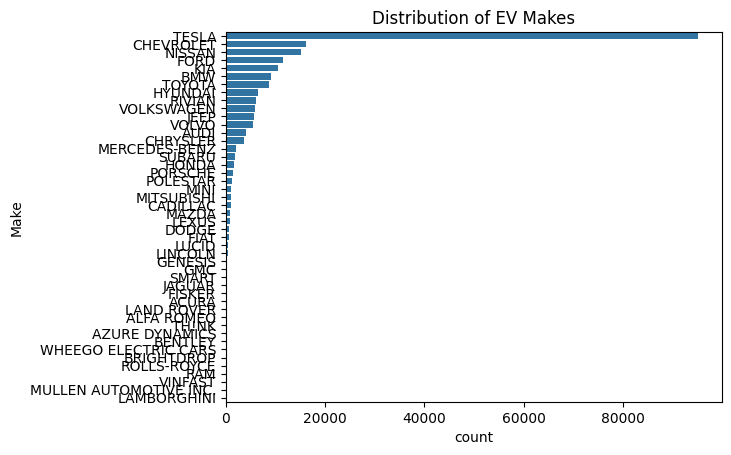

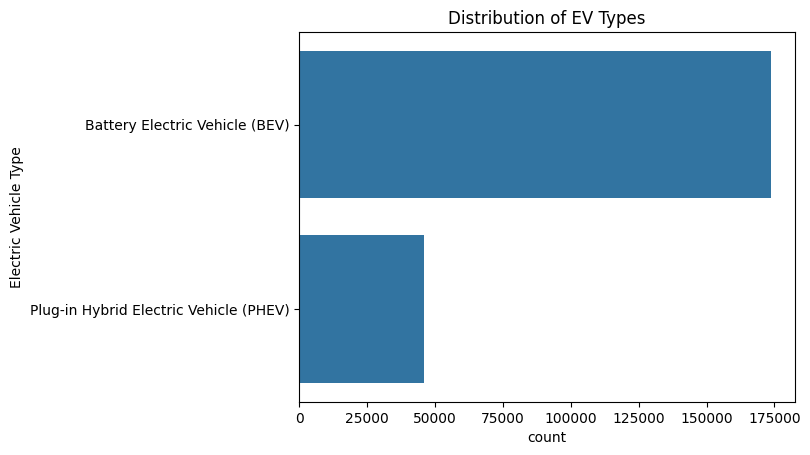

In [4]:
# Summary statistics
print(data.describe())

# Distribution of EV makes
sns.countplot(y='Make', data=data, order=data['Make'].value_counts().index)
plt.title('Distribution of EV Makes')
plt.show()

# Distribution of EV types
sns.countplot(y='Electric Vehicle Type', data=data)
plt.title('Distribution of EV Types')
plt.show()


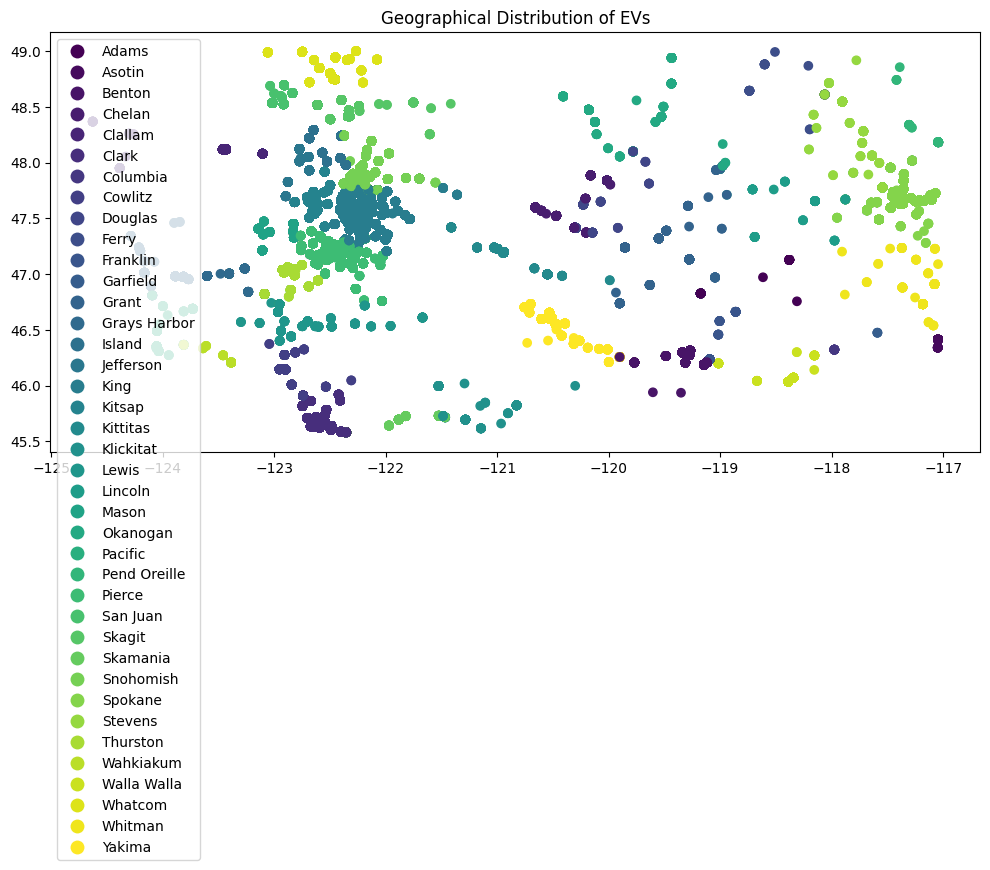

In [5]:
# Convert 'Vehicle Location' to geometrical points (if not dropped)
data['geometry'] = data['Vehicle Location'].apply(lambda x: Point([float(coord) for coord in x.strip('POINT ()').split()]))
gdf = gpd.GeoDataFrame(data, geometry='geometry')

# Plotting EV distribution by county
gdf.plot(column='County', legend=True, figsize=(12, 8), cmap='viridis')
plt.title('Geographical Distribution of EVs')
plt.show()


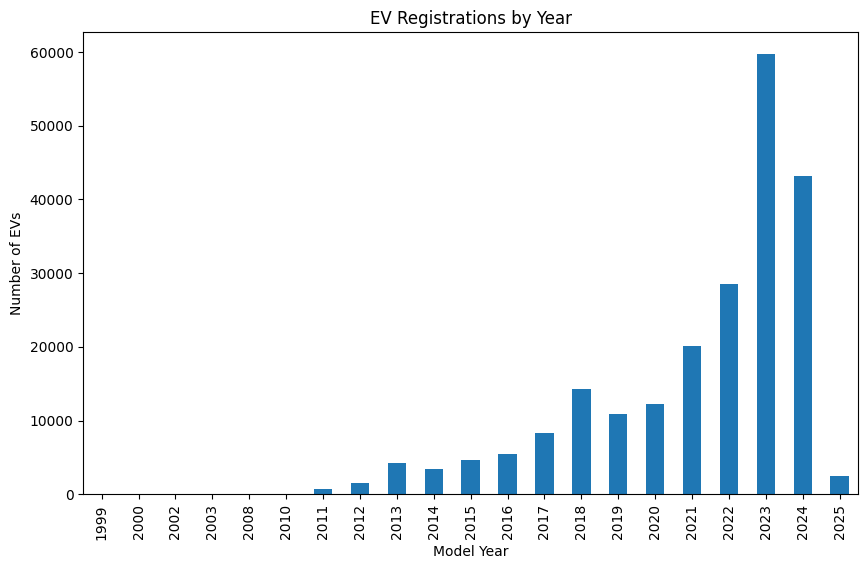

In [6]:
# EV count by year
ev_count_by_year = data.groupby('Model Year').size()

# Plotting EV registrations by year
ev_count_by_year.plot(kind='bar', figsize=(10, 6))
plt.title('EV Registrations by Year')
plt.xlabel('Model Year')
plt.ylabel('Number of EVs')
plt.show()


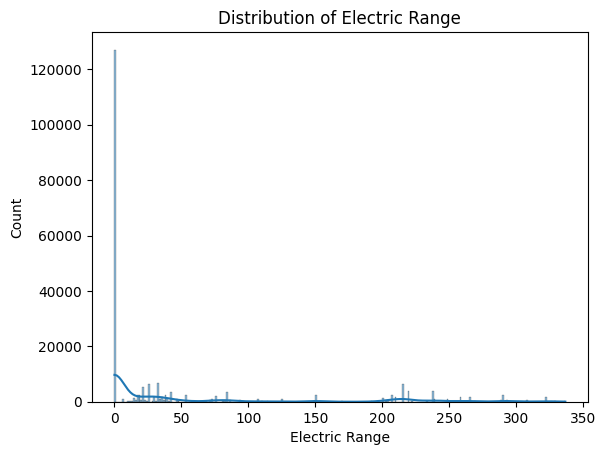

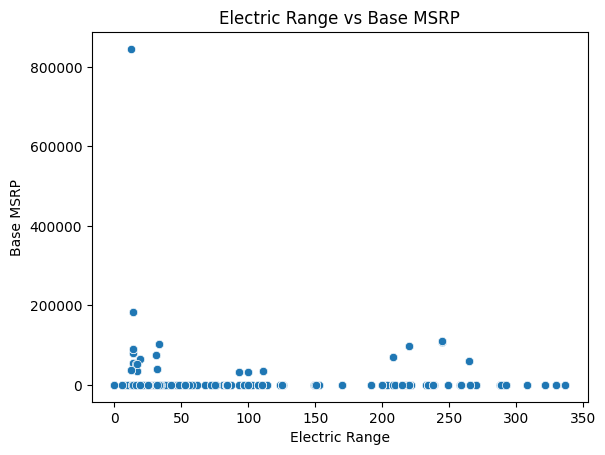

In [7]:
# Electric Range distribution
sns.histplot(data['Electric Range'], kde=True)
plt.title('Distribution of Electric Range')
plt.show()

# Relationship between Electric Range and Base MSRP
sns.scatterplot(x='Electric Range', y='Base MSRP', data=data)
plt.title('Electric Range vs Base MSRP')
plt.show()


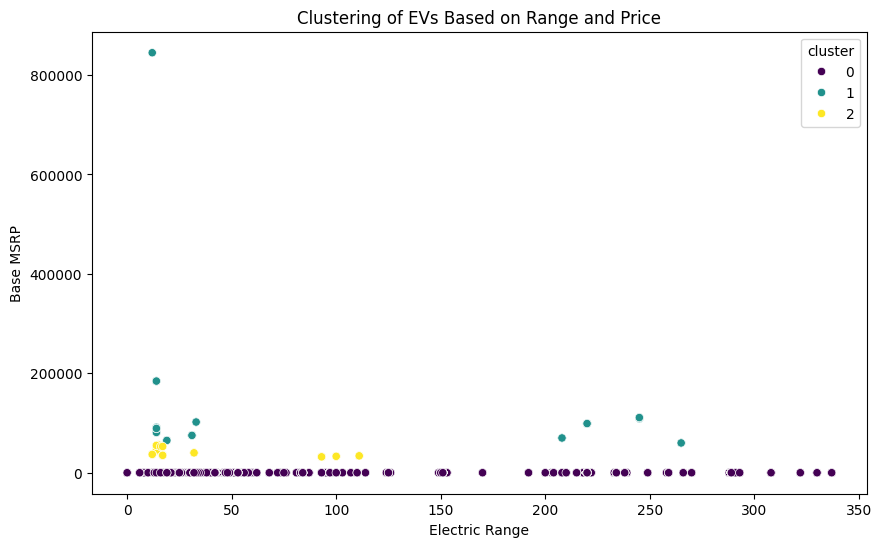

In [9]:
# Feature selection for clustering
features = data[['Electric Range', 'Base MSRP']]


# Applying KMeans clustering
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(features)

# Visualizing clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Electric Range', y='Base MSRP', hue='cluster', data=data, palette='viridis')
plt.title('Clustering of EVs Based on Range and Price')
plt.show()


Make
JAGUAR                    199.296610
WHEEGO ELECTRIC CARS      100.000000
TH!NK                     100.000000
CHEVROLET                  86.379518
FIAT                       80.165000
NISSAN                     72.280291
TESLA                      63.954219
SMART                      61.770492
AZURE DYNAMICS             56.000000
PORSCHE                    49.330877
AUDI                       45.170815
LAND ROVER                 38.810526
KIA                        34.878476
ALFA ROMEO                 33.000000
CHRYSLER                   32.148108
DODGE                      32.000000
BMW                        31.216186
MITSUBISHI                 31.194044
POLESTAR                   28.177648
TOYOTA                     27.655180
MAZDA                      25.633373
HONDA                      24.217365
LINCOLN                    23.917178
JEEP                       22.323295
BENTLEY                    22.250000
VOLKSWAGEN                 20.210417
LEXUS                      19.974

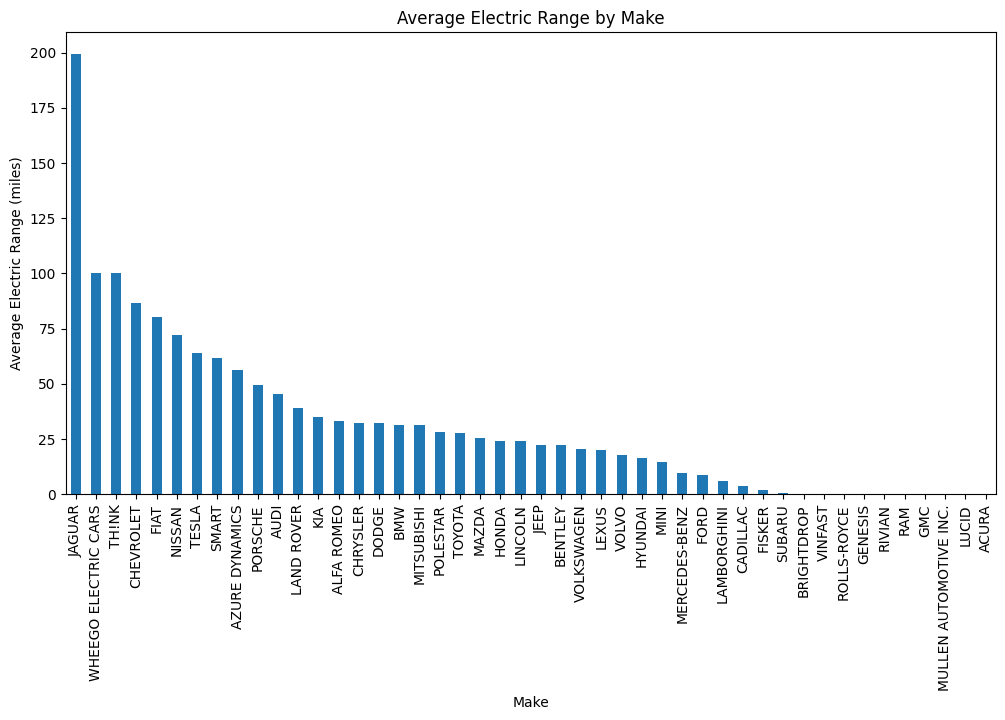

In [10]:
# Average electric range by make
avg_range_by_make = data.groupby('Make')['Electric Range'].mean().sort_values(ascending=False)
print(avg_range_by_make)

# Visualizing average range by make
avg_range_by_make.plot(kind='bar', figsize=(12, 6))
plt.title('Average Electric Range by Make')
plt.xlabel('Make')
plt.ylabel('Average Electric Range (miles)')
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing
features = data[['Electric Range', 'Model Year']]
features = pd.get_dummies(data[['Electric Range', 'Model Year', 'Make', 'Electric Vehicle Type']])
target = data['Base MSRP'].fillna(data['Base MSRP'].median())

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 2803095.019592074
R-squared: 0.9472789378332235


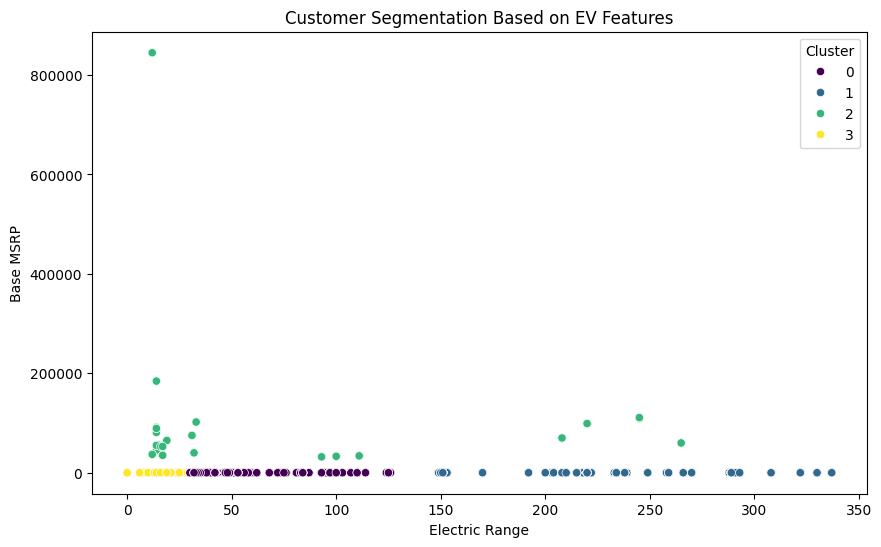

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Features selection
features = data[['Electric Range', 'Base MSRP']]

# Standardizing data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.dropna())

# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Electric Range', y='Base MSRP', hue='Cluster', data=data, palette='viridis')
plt.title('Customer Segmentation Based on EV Features')
plt.show()


<ipython-input-15-1d024aba9b75>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M').size()


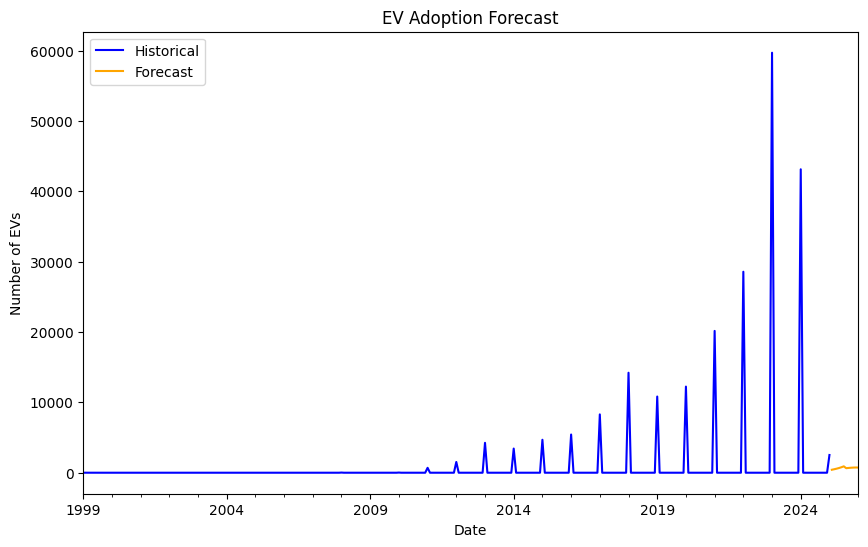

In [15]:
# Convert 'Model Year' to datetime
data['Model Year'] = pd.to_datetime(data['Model Year'], format='%Y') # Assuming 'Model Year' is in YYYY format

# Set 'Model Year' as the index
data = data.set_index('Model Year')

# Monthly data aggregation
monthly_sales = data.resample('M').size()

# ARIMA Model
model = ARIMA(monthly_sales, order=(5, 1, 0))
fit_model = model.fit()

# Forecasting
forecast = fit_model.forecast(steps=12)

# Plotting
plt.figure(figsize=(10, 6))
monthly_sales.plot(label='Historical', color='blue')
forecast.plot(label='Forecast', color='orange')
plt.title('EV Adoption Forecast')
plt.xlabel('Date')
plt.ylabel('Number of EVs')
plt.legend()
plt.show()


In [17]:
from mlxtend.frequent_patterns import apriori, association_rules

# One-hot encoding for categorical features
encoded_data = pd.get_dummies(data[['Make', 'Electric Vehicle Type']])

# Applying Apriori
frequent_itemsets = apriori(encoded_data, min_support=0.01, use_colnames=True)

# Generating association rules, providing 'num_itemsets' argument
# The 'num_itemsets' argument is set to 2 to indicate that you want rules with 2 items.
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0, num_itemsets=2)

# Display rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


                                          antecedents  \
0                                          (Make_BMW)   
1   (Electric Vehicle Type_Plug-in Hybrid Electric...   
2                                    (Make_CHEVROLET)   
3   (Electric Vehicle Type_Plug-in Hybrid Electric...   
4                                     (Make_CHRYSLER)   
5   (Electric Vehicle Type_Plug-in Hybrid Electric...   
6                                         (Make_FORD)   
7   (Electric Vehicle Type_Plug-in Hybrid Electric...   
8                                      (Make_HYUNDAI)   
9   (Electric Vehicle Type_Battery Electric Vehicl...   
10                                        (Make_JEEP)   
11  (Electric Vehicle Type_Plug-in Hybrid Electric...   
12                                         (Make_KIA)   
13  (Electric Vehicle Type_Plug-in Hybrid Electric...   
14  (Electric Vehicle Type_Battery Electric Vehicl...   
15                                      (Make_NISSAN)   
16  (Electric Vehicle Type_Batt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


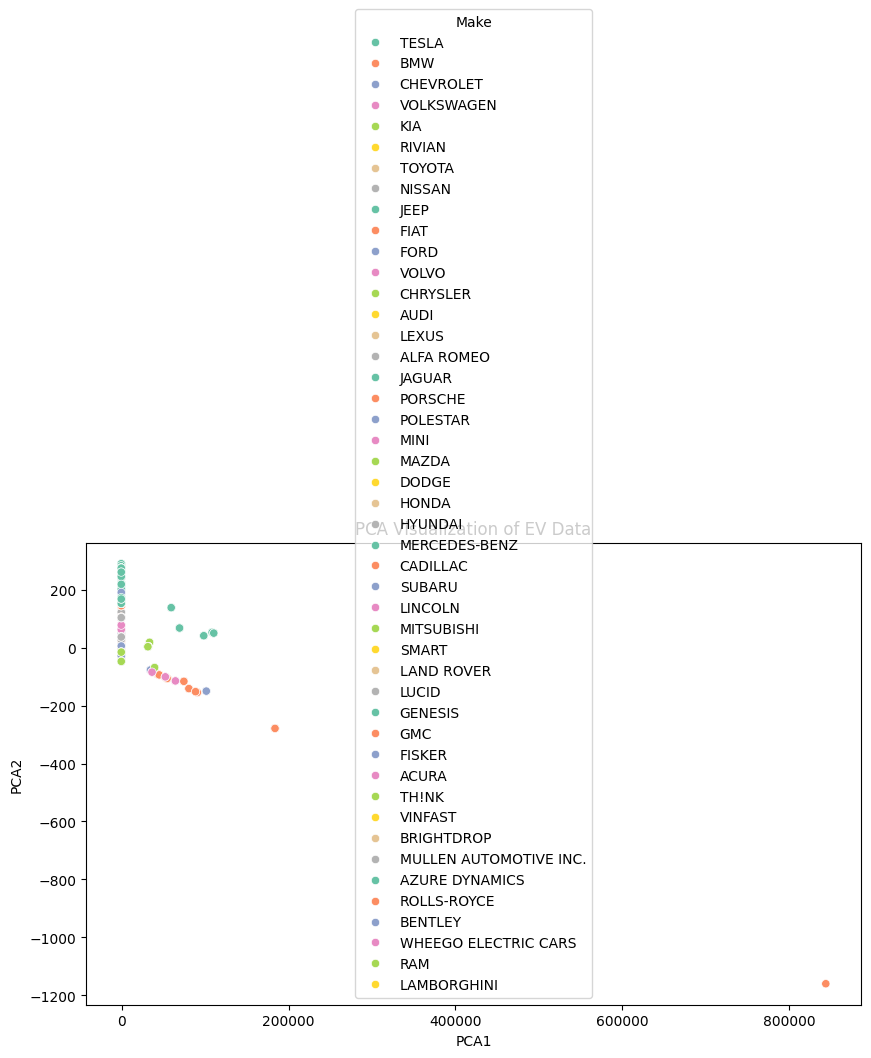

In [20]:
from sklearn.decomposition import PCA

# Selecting numerical features
# Reset the index to bring back 'Model Year' as a column
data = data.reset_index()

# *** Convert 'Model Year' back to numeric ***
data['Model Year'] = data['Model Year'].dt.year

features = data[['Electric Range', 'Base MSRP', 'Model Year']]
features = features.dropna()

# Applying PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Adding PCA results to the dataset
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Make', data=data, palette='Set2')
plt.title('PCA Visualization of EV Data')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


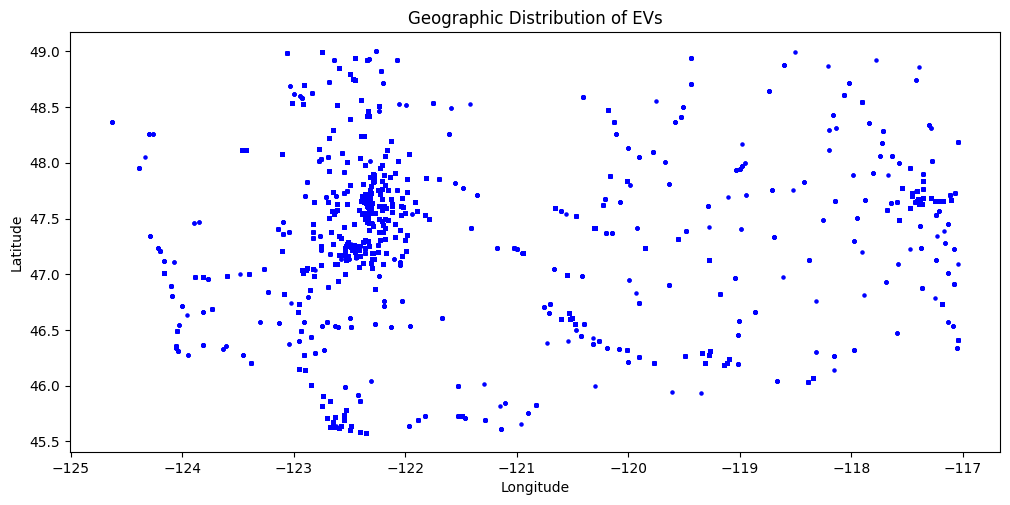

In [22]:
import geopandas as gpd
from geopandas.tools import geocode

# Creating a geodataframe
data['Coordinates'] = data['Vehicle Location'].apply(lambda x: x.split('(')[-1].split(')')[0].split())
data['Longitude'] = data['Coordinates'].apply(lambda x: float(x[0]))
data['Latitude'] = data['Coordinates'].apply(lambda x: float(x[1]))
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))

# Plotting the data on a map
gdf.plot(figsize=(12, 8), color='blue', markersize=5)
plt.title('Geographic Distribution of EVs')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


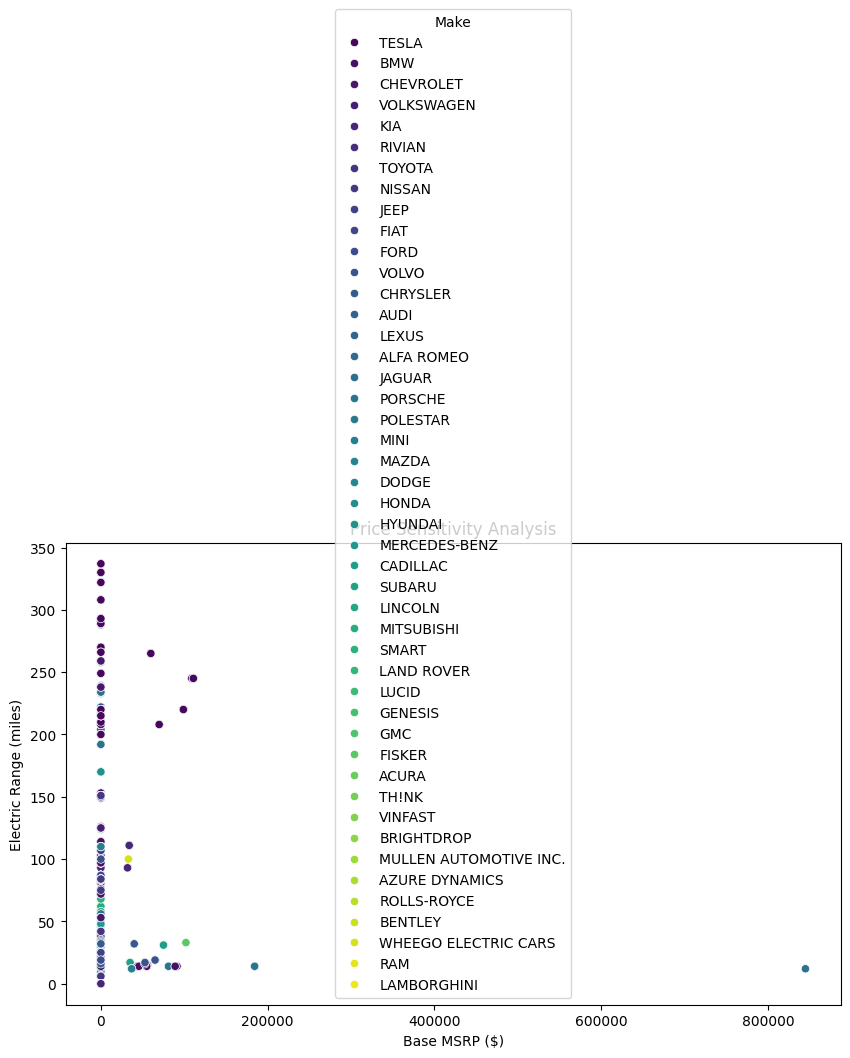

In [24]:
# Analyzing the impact of Base MSRP on Electric Range
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Base MSRP', y='Electric Range', hue='Make', data=data, palette='viridis')
plt.title('Price Sensitivity Analysis')
plt.xlabel('Base MSRP ($)')
plt.ylabel('Electric Range (miles)')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


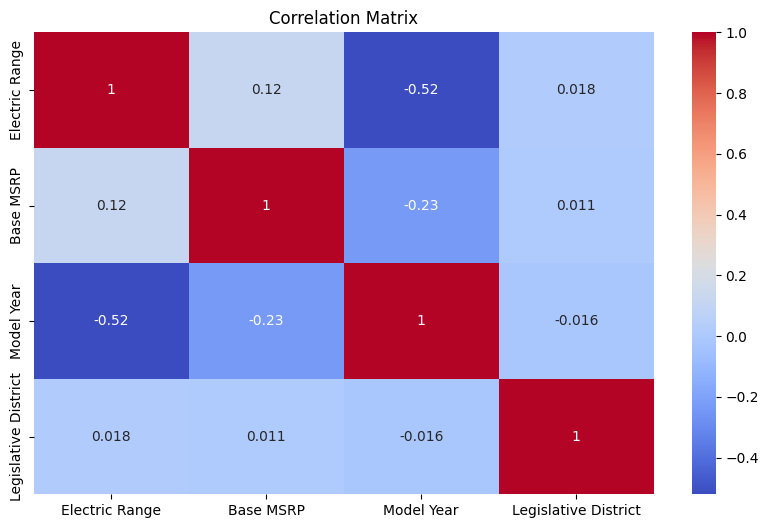

In [25]:
import seaborn as sns

# Correlation matrix
correlation_matrix = data[['Electric Range', 'Base MSRP', 'Model Year', 'Legislative District']].corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-26-8897b5760db2>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=make_counts.index, y=make_counts.values, palette='viridis')


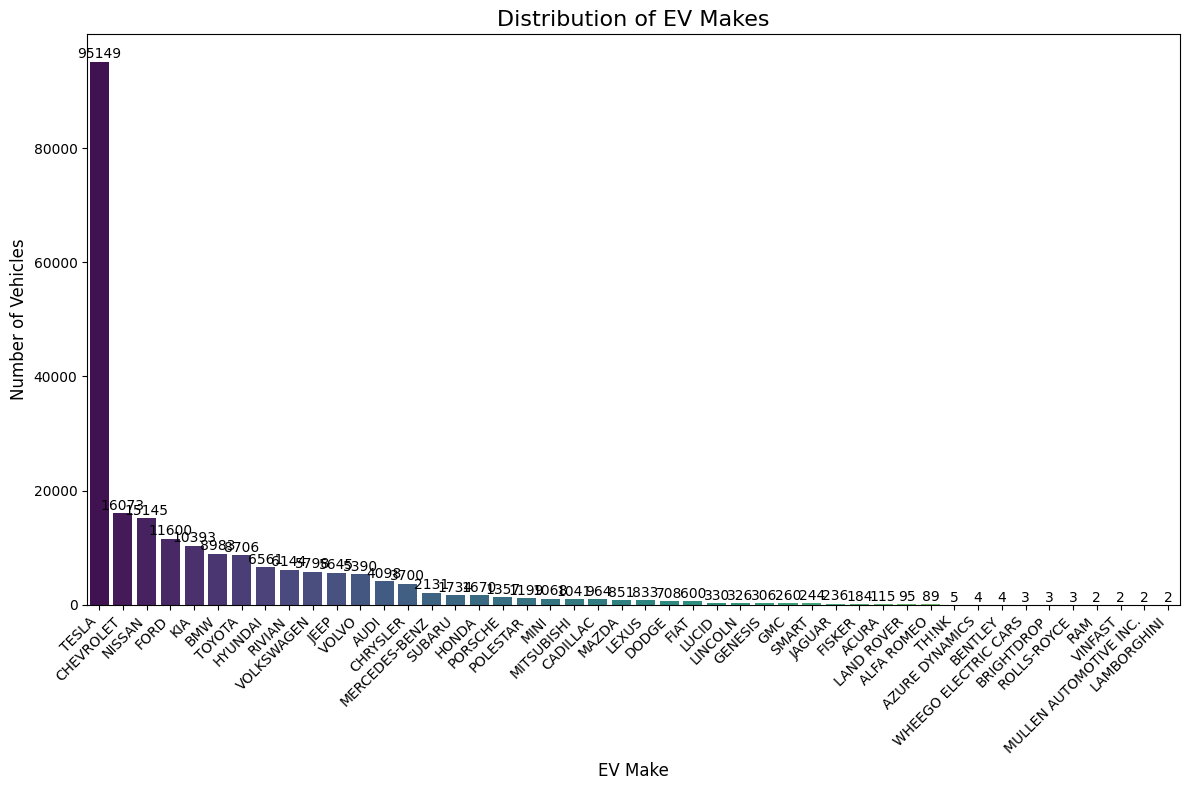

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of vehicles for each make
make_counts = data['Make'].value_counts()

# Set up the plot
plt.figure(figsize=(12, 8))
sns.barplot(x=make_counts.index, y=make_counts.values, palette='viridis')

# Add titles and labels
plt.title('Distribution of EV Makes', fontsize=16)
plt.xlabel('EV Make', fontsize=12)
plt.ylabel('Number of Vehicles', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Annotate the bar plot with the counts
for index, value in enumerate(make_counts.values):
    plt.text(index, value + 50, str(value), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd
import plotly.express as px

# Sample data loading
# Assuming 'data' is your DataFrame already loaded with EV dataset

# Count the number of vehicles for each make
make_counts = data['Make'].value_counts().reset_index()
make_counts.columns = ['Make', 'Count']

# Create an interactive bar plot using Plotly
fig = px.bar(make_counts,
             x='Make',
             y='Count',
             title='Interactive Distribution of EV Makes',
             labels={'Count': 'Number of Vehicles', 'Make': 'EV Make'},
             template='plotly_dark')

# Update layout for better readability
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title='EV Make',
    yaxis_title='Number of Vehicles',
    title_font_size=20,
    title_x=0.5
)

# Show the interactive plot
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
import plotly.express as px

# Create a box plot for electric range distribution by make
fig = px.box(data,
             x='Make',
             y='Electric Range',
             title='Electric Range Distribution by Make',
             labels={'Electric Range': 'Electric Range (miles)', 'Make': 'EV Make'},
             template='plotly_white')

# Update layout for better readability
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title='EV Make',
    yaxis_title='Electric Range (miles)',
    title_font_size=20,
    title_x=0.5
)

# Show the interactive plot
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [29]:
# Convert 'Model Year' to datetime
data['Model Year'] = pd.to_datetime(data['Model Year'], format='%Y')

# Group by model year and count vehicles
yearly_counts = data.groupby(data['Model Year'].dt.year)['VIN'].count().reset_index()
yearly_counts.columns = ['Year', 'Number of Vehicles']

# Create a line plot
fig = px.line(yearly_counts,
              x='Year',
              y='Number of Vehicles',
              title='EV Market Growth Over Time',
              labels={'Number of Vehicles': 'Number of EVs', 'Year': 'Year'},
              template='plotly_dark')

# Update layout
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of EVs',
    title_font_size=20,
    title_x=0.5
)

fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [31]:
import plotly.express as px
import pandas as pd

# Load dataset
data = pd.read_csv('EV_Population.csv')

# Group data by state and count the number of EVs per state
state_counts = data.groupby('State')['VIN'].count().reset_index()
state_counts.columns = ['State', 'Number of EVs']

# Create a choropleth map
fig = px.choropleth(
    state_counts,
    locations='State',
    locationmode='USA-states',
    color='Number of EVs',
    hover_name='State',
    hover_data={'Number of EVs': True},
    title='Geographical Distribution of EVs by State',
    color_continuous_scale='Viridis',
    scope='usa',
    template='plotly_white'
)

# Update layout for better readability
fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    geo=dict(
        lakecolor='rgb(255, 255, 255)',
        projection_type='albers usa'
    )
)

# Show the interactive plot
fig.show()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

